# **IMAGE CLASSIFICATION USING CNN**


# **Convolutional Neural Network (CNN)**
 Convolutional Neural Network models are ubiquitous and work phenomenally well on computer vision tasks like image classification, object detection, etc. So, in this notebook, we will leverage one of the popular datasets - MNIST for applying CNN.

Here's an example of Convolutional Neural Network -

<img src="https://miro.medium.com/max/1400/1*kkyW7BR5FZJq4_oBTx3OPQ.png">

When a new image is presented to the CNN, it percolates through the hidden layers until it reaches the fully connected layer at the end.

# **MNIST DATASET**

The MNIST dataset is an acronym that stands for the Modified National Institute of Standards and Technology dataset. It is a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

<img src="https://theanets.readthedocs.io/en/stable/_images/mnist-digits-small.png">

## IMPORTS

In this notebook, we'll be using Pytorch. PyTorch is an open source machine learning framework developed by Facebook's AI Research lab. It is used for applications such as computer vision and natural language processing. Here, we'll also be using matplotlib, PIL and numpy.

In [ ]:
# importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as funct
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
from google.colab import files
import os
from PIL import Image

## DATASET AND DATA LOADER

**Dataset** : It is a collection of data. Here, the dataset has two components i.e, the image and its label.

**DataLoader** : It fetches the data from a dataset and serves the data up in batches thus preventing the issue of overloading.

In [ ]:
# defining the transformations to be applied on the images
transform = transforms.Compose([transforms.Scale((32,32)), transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

# batch size during training
batch = 8

# creating the dataset for training
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# loading the data using pytorch's DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True, num_workers=2)

# creating the dataset for testing
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# loading the data using pytorch's DataLoader
testloader = torch.utils.data.DataLoader(testset, batch_size=batch, shuffle=False, num_workers=2, drop_last=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# the different class of images available in training set
classes = trainset.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## DATA VISUALIZATION

In [ ]:
# function to visualize the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

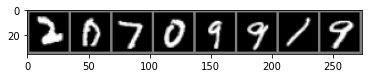

2 - two 0 - zero 7 - seven 0 - zero 9 - nine 9 - nine 1 - one 9 - nine


In [ ]:
# shows the imput of dataloader in the form of grid of batch number
detaiter = iter(trainloader)
img, labels = detaiter.next()
imshow(torchvision.utils.make_grid(img))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch)))

## MODEL

Here we define the training pipeline.

<img src = "https://miro.medium.com/max/1400/1*0NwaOkzvom6YpMZoIgWTiQ.png">

**Convolution** : It has a simple application of a filter to an input that results in an activation. Repeated application of the same filter to an input results in a map of activations called a feature map, indicating the locations and strength of a detected feature in an input, such as an image.

<img src = "https://miro.medium.com/max/543/1*Ff6mG3aPdWFkjb6hZPy3Xw.gif">

**Pooling** : Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network.

<img src = "https://developers.google.com/machine-learning/practica/image-classification/images/maxpool_animation.gif">

**Linear** : It creates single layer feed forward network with input as in_features and output as out_features.



**ReLU** : It helps to prevent the exponential growth in the computation required to operate the neural network.

<img src = "https://miro.medium.com/max/357/1*oePAhrm74RNnNEolprmTaQ.png">

In [ ]:
# Model
class NNmodel(nn.Module):
    def __init__(self):
        super(NNmodel, self).__init__()
        # MNIST datasets have 1 channel
        
        # Conv2d(in_channel, out_channel, kernel_size)
        self.conv1 = nn.Conv2d(1, 6, 5)
        
        # MaxPool2d(kernel_size, stride)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Conv2d(in_channel, out_channel, kernel_size)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Linear(in_features, out_features)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    # forward pass to predict the result
    def forward(self, x):
        # different layers
        x = self.pool(funct.relu(self.conv1(x)))
        x = self.pool(funct.relu(self.conv2(x)))
        
        # view(-1) reverses the dimension of the tensor
        x = x.view(-1, 16*5*5)
        x = funct.relu(self.fc1(x))
        x = funct.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## TRAINING UTILS, LOSS & OPTIMISER

In [ ]:
# check if cuda available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
step = 0
loss_train = []
loss_val = []

# import the model
net = NNmodel()
net = net.to(device)
net = net.train()

min_loss = 100
patience = 5
training_loss_store = []
validation_loss_store = []

Cross Entropy Loss :

<img src = 'https://i.stack.imgur.com/gNip2.pnghttps://i.stack.imgur.com/gNip2.png'>

In [ ]:
# cross entropy loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## TRAINING

In [ ]:
file = open('logs_test4_epoch100_with_max_pool.txt', 'w')

print('Training Started.............................................')
file.write('Training Started.............................................\n')
start_time = time.time()
for epoch in range(150):  # loop over the dataset multiple times
    #file.write('##############################TRAINING###############################\n')
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        step+=1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss_train.append(loss.item())
        training_loss_store.append([epoch, loss.item()])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.5f' %(epoch + 1, i + 1, running_loss / 2000))
            file.write('epoch = '+ str(epoch + 1) + '\t' +'step = '+ str(step) +'\t'+'train_loss = '+'\t'+str(np.mean(loss_train)) +'\n')
            loss_train = []
            running_loss = 0.0
            
    print('Finished training for epoch ' + str(epoch) + ' time taken = ' + str(time.time() - start_time))
    file.write('Finished training for epoch ' + str(epoch) + ' time taken = ' + str(time.time() - start_time) + '\n')
    file.write('##################################evaluation##############################\n')
    print('################################evaluation###########################\n')
    with torch.no_grad():
        val_loss = 0
        net.eval()
        
        for i, data in enumerate(testloader, 0):
            step+=1
            inputs, labels = data[0].to(device),data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss_val.append(loss.item())
            validation_loss_store.append([epoch, loss.item()])
            val_loss += loss
            
        val_loss = val_loss/float(i + 1)
        
        if val_loss < min_loss:
            min_loss = val_loss
            no_impr_epoch = 0
            
            #save the best model
            print(str(val_loss))
            torch.save(net.state_dict(), 'xyz_epoch_'+str(epoch+1)+'.pt')
            
            print('performance improved with validation loss ' + str(val_loss))
            file.write('--------------------------------------------------------------------\n')
            file.write('performance improved with validation loss =  ' + str(val_loss) + '\n')
            
            file.write('epoch = '+ str(epoch + 1) + '\t' +'step = '+ str(step) +'\t'+'val_loss = '+'\t'+str(np.mean(loss_val)) +'\n')
            file.write('--------------------------------------------------------------------\n\n')
            loss_val = []
        else:
            no_impr_epoch += 1
            print('no improvement with prev best model ' + str(no_impr_epoch) + 'th')
            file.write('no improvement with prev best model ' + str(no_impr_epoch) + 'th \n')
            
        if no_impr_epoch > patience:
            print('stop training')
            file.write('stop training')
            break
    
print('Finished Training................................................')
file.write('Finished Training................................................\n')
end_time = time.time()
file.write('Training time:- ' + str(end_time - start_time))
file.close()

Streaming output truncated to the last 5000 lines.
[4,  6240] loss: 0.00043
[4,  6260] loss: 0.00022
[4,  6280] loss: 0.00019
[4,  6300] loss: 0.00030
[4,  6320] loss: 0.00029
[4,  6340] loss: 0.00059
[4,  6360] loss: 0.00029
[4,  6380] loss: 0.00075
[4,  6400] loss: 0.00007
[4,  6420] loss: 0.00028
[4,  6440] loss: 0.00048
[4,  6460] loss: 0.00017
[4,  6480] loss: 0.00039
[4,  6500] loss: 0.00029
[4,  6520] loss: 0.00030
[4,  6540] loss: 0.00070
[4,  6560] loss: 0.00063
[4,  6580] loss: 0.00009
[4,  6600] loss: 0.00024
[4,  6620] loss: 0.00071
[4,  6640] loss: 0.00064
[4,  6660] loss: 0.00034
[4,  6680] loss: 0.00064
[4,  6700] loss: 0.00066
[4,  6720] loss: 0.00016
[4,  6740] loss: 0.00055
[4,  6760] loss: 0.00025
[4,  6780] loss: 0.00071
[4,  6800] loss: 0.00009
[4,  6820] loss: 0.00010
[4,  6840] loss: 0.00050
[4,  6860] loss: 0.00024
[4,  6880] loss: 0.00007
[4,  6900] loss: 0.00020
[4,  6920] loss: 0.00011
[4,  6940] loss: 0.00013
[4,  6960] loss: 0.00038
[4,  6980] loss: 0.00036

## LOAD MODEL

In [ ]:
# loading one of the models
!gdown --id 1yCzEwzbqVmVQ9O2G8GMolzzO0g5dGLns
PATH = 'xyz_epoch_9.pt'
model = NNmodel()
model.load_state_dict(torch.load(PATH))
model.eval()

Downloading...
From: https://drive.google.com/uc?id=1yCzEwzbqVmVQ9O2G8GMolzzO0g5dGLns
To: /content/xyz_epoch_9.pt
100% 250k/250k [00:00<00:00, 59.0MB/s]


NNmodel(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## TESTING

In [ ]:
# visualization of the testing set
dataiter = iter(testloader)
images, labels = dataiter.next()

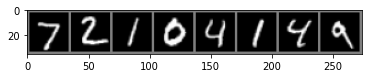

Ground Truth:  7 - seven 2 - two 1 - one 0 - zero 4 - four 1 - one 4 - four 9 - nine


In [ ]:
# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print('Ground Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch)))

In [ ]:
# testing against one of the models after training
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# printing prediction
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch)))

Predicted:  7 - seven 2 - two 1 - one 0 - zero 4 - four 1 - one 4 - four 9 - nine


## ACCURACY

In [ ]:
# checking the accuracy after the testing
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0], data[1]
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 3776 test images: 99 %


In [ ]:
# testing the accuracy of the individual classes
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0 - zero : 99 %
Accuracy of 1 - one : 99 %
Accuracy of 2 - two : 99 %
Accuracy of 3 - three : 99 %
Accuracy of 4 - four : 99 %
Accuracy of 5 - five : 98 %
Accuracy of 6 - six : 98 %
Accuracy of 7 - seven : 98 %
Accuracy of 8 - eight : 98 %
Accuracy of 9 - nine : 98 %


## TESTING ON A RANDOM IMAGE

Let's test on a random image.

In [ ]:
# uploading the image
!gdown --id 16UDdyu2qbcp0b0dL326d7VIT4qHCdaeA

Downloading...
From: https://drive.google.com/uc?id=16UDdyu2qbcp0b0dL326d7VIT4qHCdaeA
To: /content/img2.png
100% 593/593 [00:00<00:00, 639kB/s]


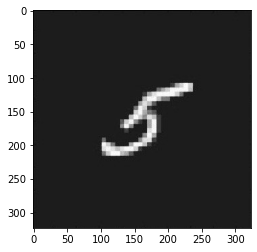

In [ ]:
# plotting the image
plt.imshow(np.asarray(Image.open('img2.png')), "gray")

In [ ]:
# defining the transformations
testing_transforms = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

In [ ]:
# giving the image input
input = testing_transforms(Image.open('img2.png'))

In [ ]:
# testing against the model and finding the output
output = model(input.unsqueeze(0))
_, predicted = torch.max(output, 1)
print(classes[predicted])

5 - five
